<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#loading-data" data-toc-modified-id="loading-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>loading data</a></span></li><li><span><a href="#converting-to-binary-classification-problem" data-toc-modified-id="converting-to-binary-classification-problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>converting to binary classification problem</a></span></li><li><span><a href="#cross-validation" data-toc-modified-id="cross-validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>cross validation</a></span></li><li><span><a href="#submission" data-toc-modified-id="submission-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>submission</a></span></li></ul></div>

In [1]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
from pathlib import Path

import os
import gc

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

pd.set_option("max_colwidth", -1)
pd.set_option("max_columns", 500)
pd.set_option("max_rows", 500)

plt.style.use('fivethirtyeight')
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

### loading data

In [2]:
train = pd.read_csv("Train.csv", index_col=None)
print(train.shape)
train.head()

(2508, 10)


,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner
0,5,4,37,4,Home,Away,Second,First,Dec,4
1,1,14,84,7,Neutral,Neutral,First,Second,Sep,1
2,9,15,47,9,Home,Away,First,Second,Feb,9
3,7,2,102,6,Home,Away,First,Second,Aug,2
4,6,8,46,5,Home,Away,First,Second,Aug,6


In [3]:
test = pd.read_csv("Test.csv", index_col=None)
print(test.shape)
test.head()

(1075, 9)


,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch
0,2,4,34,1,Home,Away,First,Second,Oct
1,14,1,19,15,Home,Away,First,Second,Mar
2,9,10,130,14,Neutral,Neutral,Second,First,Dec
3,9,10,8,9,Home,Away,First,Second,Dec
4,5,15,130,14,Neutral,Neutral,First,Second,Oct


In [4]:
target = 'MatchWinner'
cat_cols = ['Team1', 'Team2', 'HostCountry', 'Team1_Venue', 'Team2_Venue', 
            'Team1_Innings', 'Team2_Innings', 'MonthOfMatch', 'Stadium']
print("cat cols {}".format(cat_cols))
num_cols = [col for col in train.columns if col not in [target]+cat_cols]
print("num cols {}".format(num_cols))

cat cols ['Team1', 'Team2', 'HostCountry', 'Team1_Venue', 'Team2_Venue', 'Team1_Innings', 'Team2_Innings', 'MonthOfMatch', 'Stadium']
num cols []


In [5]:
win_count = train[target].value_counts()
win_count

1     379
5     318
10    316
14    262
13    246
12    245
4     237
9     223
15    87 
2     70 
6     33 
0     27 
7     24 
11    18 
8     15 
3     8  
Name: MatchWinner, dtype: int64

In [6]:
total_matches = {}
for index, row in train.iterrows():
    total_matches[row['Team1']] = total_matches.get(row['Team1'], 0) + 1 
    total_matches[row['Team2']] = total_matches.get(row['Team2'], 0) + 1
total_matches = pd.Series(total_matches)
total_matches

5     602
4     452
1     590
14    506
9     476
15    322
7     98 
2     225
6     76 
8     45 
13    517
12    384
10    566
3     49 
0     56 
11    52 
dtype: int64

In [7]:
team_win_pct = win_count.div(total_matches)
team_win_pct

0     0.482143
1     0.642373
2     0.311111
3     0.163265
4     0.524336
5     0.528239
6     0.434211
7     0.244898
8     0.333333
9     0.468487
10    0.558304
11    0.346154
12    0.638021
13    0.475822
14    0.517787
15    0.270186
dtype: float64

### converting to binary classification problem

In [8]:
train['MatchWinner'] = (train['Team1']==train['MatchWinner']).astype(int)
train['MatchWinner'].head()

0    0
1    1
2    1
3    0
4    1
Name: MatchWinner, dtype: int64

In [9]:
overall = train.append(test, sort=False)

unwanted_cols = ['Team2_Venue', 'Team2_Innings', 'Stadium', 'MonthOfMatch']

overall['Team1_winpct'] = overall['Team1'].map(team_win_pct)
overall['Team2_winpct'] = overall['Team2'].map(team_win_pct)
overall['winpct_diff'] = (overall['Team1'].map(team_win_pct) - overall['Team2'].map(team_win_pct))

sel_cols = [col for col in cat_cols if col not in unwanted_cols]
print("selected features are {}".format(sel_cols))
overall[sel_cols] = overall[sel_cols].astype('category')
for col in sel_cols:
    overall[col] = overall[col].cat.codes
        
overall = overall.drop(unwanted_cols, axis=1)

train_data, test_data = overall[:len(train)].reset_index(drop=True), overall[len(train):].reset_index(drop=True)
train_data.shape, test_data.shape

selected features are ['Team1', 'Team2', 'HostCountry', 'Team1_Venue', 'Team1_Innings']


((2508, 9), (1075, 9))

In [10]:
overall.head()

,Team1,Team2,HostCountry,Team1_Venue,Team1_Innings,MatchWinner,Team1_winpct,Team2_winpct,winpct_diff
0,5,4,4,1,1,0.0,0.528239,0.524336,0.003903
1,1,14,7,2,0,1.0,0.642373,0.517787,0.124586
2,9,15,9,1,0,1.0,0.468487,0.270186,0.198301
3,7,2,6,1,0,0.0,0.244898,0.311111,-0.066213
4,6,8,5,1,0,1.0,0.434211,0.333333,0.100877


### cross validation

In [11]:
drop_cols = []

In [12]:
%%time

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import log_loss

preds = []

valid_score_list = []

cv = StratifiedKFold(n_splits=5) 

for i, (train_ind, test_ind) in enumerate(cv.split(train_data, train_data[target])):
    data_train = train_data.iloc[train_ind].reset_index(drop=True)
    data_valid = train_data.iloc[test_ind].reset_index(drop=True)
    data_test = test_data.reset_index(drop=True)

    for col in ['Team1', 'Team2']:
        mean_val = data_train.groupby(col)[target].mean()
        data_train[col] = data_train[col].map(mean_val)
        data_valid[col] = data_valid[col].map(mean_val)
        data_test[col] = data_test[col].map(mean_val)
            
    clf = lgb.LGBMClassifier(verbose=0, n_estimators=1000,
                             num_leaves=5,
                             min_child_samples=60,
                             colsample_bytree=0.8
                            )

    X_train = data_train.drop([target]+drop_cols, axis=1)
    X_valid = data_valid.drop([target]+drop_cols, axis=1)
    X_test = data_test.drop([target]+drop_cols, axis=1)
    
    clf.fit(X_train, 
            data_train[target],#)
            eval_set=[(X_valid, data_valid[target])], 
            early_stopping_rounds=50, 
            verbose=0)
    
    valid_prediction = clf.predict_proba(X_valid)
    test_prediction = clf.predict_proba(X_test)    
    valid_prediction = np.clip(valid_prediction, 0.05, 0.95)

    valid_score = log_loss(data_valid[target], valid_prediction)
    valid_score_list.append(valid_score)
    print("FOLD:{} SCORE:{:0.2f}".format(i+1, valid_score))
    
    preds.append(test_prediction)
    
print("CV score is {}".format(np.mean(valid_score_list)))

FOLD:1 SCORE:0.61
FOLD:2 SCORE:0.59
FOLD:3 SCORE:0.64
FOLD:4 SCORE:0.60
FOLD:5 SCORE:0.63
CV score is 0.6138881507658216
CPU times: user 7.09 s, sys: 626 ms, total: 7.72 s
Wall time: 1.34 s


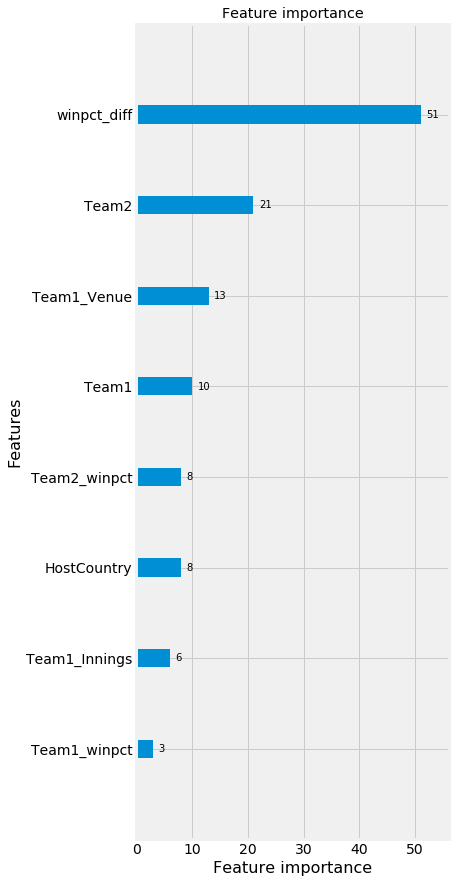

In [13]:
lgb.plot_importance(clf, figsize=(5,15))

### submission

In [14]:
prediction = np.mean(preds, axis=0)
prediction = np.clip(prediction, 0.05, 0.95)

In [15]:
result = np.zeros((len(test), 16))

for i, (team1, team2) in enumerate(test[['Team1', 'Team2']].values):
    result[i, team1] = prediction[i, 1]
    result[i, team2] = prediction[i, 0]

In [16]:
sub = pd.DataFrame(result, columns=range(16))
sub.to_excel("lgb_v2.xlsx", index=None)

sub.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.000000,0.284349,0.0,0.715651,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.610252,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.389748,0.000000
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.415653,0.584347,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.509564,0.490436,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,0.787131,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.212869
